# Ames Housing Pricing prediction

In [1]:
# Import libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

In [9]:
os.chdir('/Users/karneshjain/Desktop/kaggle/ames')

In [10]:
train_data = pd.read_csv('train.csv')
val_data = pd.read_csv('test.csv')

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [12]:
y = train_data.SalePrice

/Users/karneshjain/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


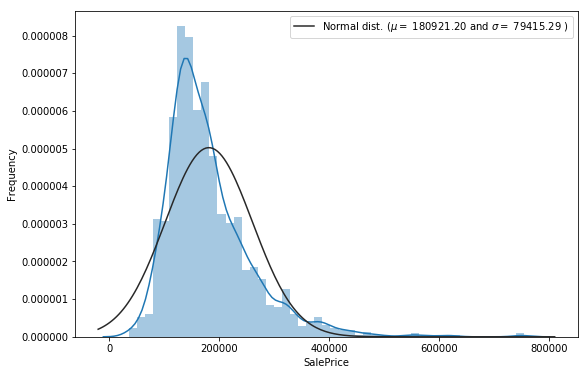

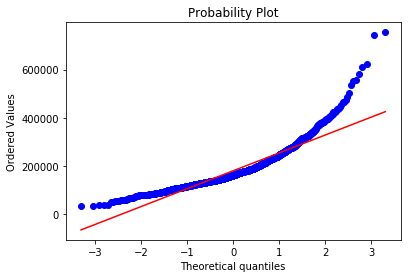

In [13]:
def target_plot(target_y):
	plt.subplots(figsize = (9,6))
	sns.distplot(target_y,fit = stats.norm)
	(mu, sigma) = stats.norm.fit(y)
	plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
	plt.ylabel('Frequency')
	
	fig = plt.figure()
	stats.probplot(y, plot=plt)
	plt.show()

target_plot(y)

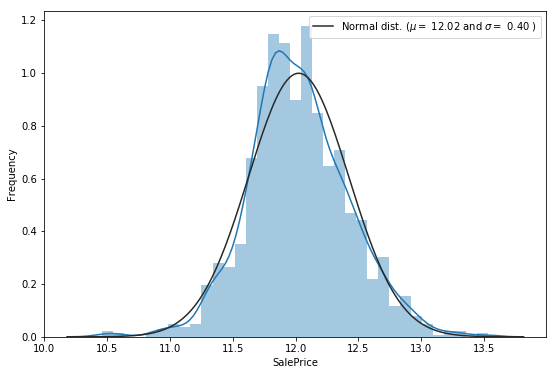

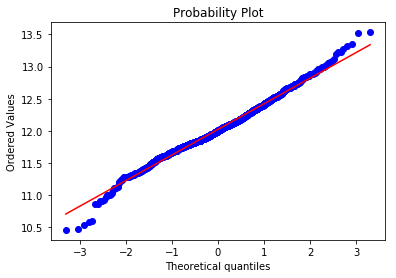

In [14]:
y = np.log1p(y)
target_plot(y)

In [15]:
# Missing Values and their number
train_data.columns[train_data.isnull().any()] 

Nnull = train_data.isnull().sum()/len(train_data)*100
Nnull = Nnull[Nnull>0]
Nnull.sort_values(inplace=True, ascending=False)
print(Nnull)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64


In [16]:
# Imputing Missing Values
train_data['LotFrontage'] = train_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

train_data['FireplaceQu'] = train_data['FireplaceQu'].fillna('None')

for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    train_data[col] = train_data[col].fillna(int(0))

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train_data[col] = train_data[col].fillna('None')

for col in ('BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond', 'BsmtQual'):
    train_data[col] = train_data[col].fillna('None')

train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(int(0))
train_data['MasVnrType'] = train_data['MasVnrType'].fillna('None')
train_data['Electrical'] = train_data['Electrical'].fillna(train_data['Electrical']).mode()[0]

In [17]:
# dropping columns with more than 80% missing data
train_data = train_data.drop(['Utilities', 'PoolQC', 'MiscFeature', 'Fence', 'Alley'], axis=1)

In [18]:
# Check null values
print(train_data.isnull().any().any())

False


In [19]:
# Encoding

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold', 'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood',
        'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'Foundation', 'GarageType', 
        'SaleType', 'SaleCondition', 'Electrical', 'Heating')

for c in cols:
    my_encoder = LabelEncoder() 
    my_encoder.fit(list(train_data[c].values)) 
    train_data[c] = my_encoder.transform(list(train_data[c].values))

In [20]:
X = train_data.loc[:, train_data.columns != 'SalePrice']

train_X, test_X, train_y, test_y = train_test_split(X,y, random_state = 1)

In [21]:
def score_dataset(train_X, test_X, train_y, test_y):
    ames_model = RandomForestRegressor(random_state = 1)
    ames_model.fit(train_X,train_y)
    prediction = ames_model.predict(test_X)
    return mean_absolute_error(np.expm1(test_y), np.expm1(prediction))

In [22]:
def score_boost(train_X, test_X, train_y, test_y):
	model = XGBRegressor(n_estimators=1000, learning_rate=0.036)
	model.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(test_X, test_y)], verbose=False)
	pred = model.predict(test_X)
	return mean_absolute_error(np.expm1(test_y), np.expm1(pred))

In [23]:
print("Mean Absolute Error from Random Forest Regression:")
print(score_dataset(train_X, test_X, train_y, test_y))   

print("Mean Absolute Error from XGBoost:")
print(score_boost(train_X, test_X, train_y, test_y))

Mean Absolute Error from Random Forest Regression:
18930.403106238613
Mean Absolute Error from XGBoost:


15256.266406250004
